In [0]:
#Update to Tensorflow 2.0 
#!pip install -U tensorflow

# Use the %tensorflow_version magic if in colab.
try:
  %tensorflow_version 2.x
except Exception:
  pass

In [0]:
#Check GPU on Colab 
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, 
and then re-execute this cell.


In [0]:
#imports
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, accuracy_score, auc
from sklearn import metrics

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time 
from collections import OrderedDict 

import os
import shutil

##Data

In [0]:
create_dir = False

directory_in_str = '/content/drive/My Drive/Northwestern/MSDS462/Final Project/data/CUB_200_2011/CUB_200_2011/images'
base_dir = '/content/drive/My Drive/Northwestern/MSDS462/Final Project/data'

#Create Train Validation and Test directories
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

if create_dir:
    os.mkdir(train_dir)
    os.mkdir(validation_dir)
    os.mkdir(test_dir)

In [0]:
#Create train,validation,test directories and load folder structure and files
if create_dir:
    dir_names = list(d for d in os.listdir(directory_in_str))

    for dir_name in dir_names:
        print (dir_name)
        bird_path = directory_in_str+'/'+dir_name

        if len(os.listdir(bird_path)) >= 58:
            train_bird_dir = os.path.join(train_dir,dir_name)
            os.mkdir(train_bird_dir)

            validation_bird_dir = os.path.join(validation_dir, dir_name)
            os.mkdir(validation_bird_dir)

            test_bird_dir = os.path.join(test_dir, dir_name)
            os.mkdir(test_bird_dir)


            for cnt, file in enumerate(os.listdir(bird_path)):
                filename = os.fsdecode(file)
                
                if cnt <= 37:
                    print('Train ',cnt,': ',filename)
                    src = os.path.join(bird_path, filename)
                    dst = os.path.join(train_bird_dir, filename)
                    shutil.copyfile(src, dst)

                elif cnt > 37 and cnt <= 47:
                    print('Val ',cnt,': ',filename)
                    src = os.path.join(bird_path, filename)
                    dst = os.path.join(validation_bird_dir, filename)
                    shutil.copyfile(src, dst)

                elif cnt > 47 and cnt <= 57:
                    print('Test ',cnt,': ',filename)
                    src = os.path.join(bird_path, filename)
                    dst = os.path.join(test_bird_dir, filename)
                    shutil.copyfile(src, dst)
                else:
                    print('not used',cnt,': ',filename)


In [0]:
#Utility to list entire data structure in base_dir = '/content/drive/My Drive/Northwestern/MSDS462/Final Project/data'
for dir_name in ['validation','test']:  #'train' ,'validation', 'test'
    print (dir_name)
    tvt_path = base_dir+'/'+dir_name
    bcnt = 0
    for cnt, bird in enumerate(os.listdir(tvt_path)):
        birdname = os.fsdecode(bird)
        print (birdname)
        bird_path = tvt_path+'/'+ birdname
        bcnt += 1
        fcnt = 0
        for birdfile in (os.listdir(bird_path)):
            print('dir_name: ', dir_name, 'birdname: ', birdname, 'file: ', birdfile)
            fcnt += 1
        print('file count: ', fcnt) 
    print('bird count: ', bcnt) 

In [0]:
#list bird classes and write to CSV
birdclass = pd.DataFrame(columns=['birdclass', 'birdname', 'bird_num'])
base_dir = '/content/drive/My Drive/Northwestern/MSDS462/Final Project/data'
for dir_name in ['test']:  #train,validation,test 'train' ,'validation','test'
    tvt_path = base_dir+'/'+dir_name
    for cnt, bird in enumerate(os.listdir(tvt_path)):
        bird_num = os.fsdecode(bird)
        birdname = bird_num.split(".")[1]
        print (cnt, birdname, bird_num)
        birdclass.loc[cnt] = [cnt, birdname, bird_num]

birdclass.to_csv('/content/drive/My Drive/Northwestern/MSDS462/Final Project/birdclass.csv', index = False)

0 Black_footed_Albatross 001.Black_footed_Albatross
1 Laysan_Albatross 002.Laysan_Albatross
2 Sooty_Albatross 003.Sooty_Albatross
3 Groove_billed_Ani 004.Groove_billed_Ani
4 Brewer_Blackbird 009.Brewer_Blackbird
5 Red_winged_Blackbird 010.Red_winged_Blackbird
6 Rusty_Blackbird 011.Rusty_Blackbird
7 Bobolink 013.Bobolink
8 Lazuli_Bunting 015.Lazuli_Bunting
9 Indigo_Bunting 014.Indigo_Bunting
10 Painted_Bunting 016.Painted_Bunting
11 Yellow_breasted_Chat 020.Yellow_breasted_Chat
12 Gray_Catbird 019.Gray_Catbird
13 Eastern_Towhee 021.Eastern_Towhee
14 Brandt_Cormorant 023.Brandt_Cormorant
15 Pelagic_Cormorant 025.Pelagic_Cormorant
16 Bronzed_Cowbird 026.Bronzed_Cowbird
17 Shiny_Cowbird 027.Shiny_Cowbird
18 Brown_Creeper 028.Brown_Creeper
19 American_Crow 029.American_Crow
20 Black_billed_Cuckoo 031.Black_billed_Cuckoo
21 Fish_Crow 030.Fish_Crow
22 Gray_crowned_Rosy_Finch 034.Gray_crowned_Rosy_Finch
23 Yellow_billed_Cuckoo 033.Yellow_billed_Cuckoo
24 Northern_Flicker 036.Northern_Flicker
2

## MobileNetV2


### Model

In [0]:
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(weights='imagenet',
                         include_top=False,
                         input_shape=(224, 224, 3))
for layer in base_model.layers[:]:
  layer.trainable = False

model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(1280, activation='relu'))
model.add(layers.Dense(181, activation='softmax'))
model.summary()


9412608/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1280)              1639680   
_________________________________________________________________
dense_1 (Dense)              (None, 181)               231861    
Total params: 4,129,525
Trainable params: 1,871,541
Non-trainable params: 2,257,984
_________________________________________________________________


## Data Generators

In [0]:
# Setup data generators and use data augmentation in train data generator
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=52,
        class_mode='categorical')

# generator with no augmentation
test_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size=30,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=30,
        class_mode='categorical',
        shuffle=False)

Found 6878 images belonging to 181 classes.
Found 1810 images belonging to 181 classes.
Found 1810 images belonging to 181 classes.


In [0]:
# set model to run for epochs unless early stopping rule is met
earlystop_callback = \
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',\
    min_delta=0.01, patience=5, verbose=0, mode='auto',\
    baseline=None, restore_best_weights=False)

#compile - set learning rate very low for fine tuning
model.compile(optimizer = optimizers.Adam(lr=.001),
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

begin_time = time()

#fit model 
history = model.fit(
      train_generator,
      steps_per_epoch= 132,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=60,
      callbacks = [earlystop_callback]) 

#capture timing
execution_time = time() - begin_time
print('\nTime of execution for training (seconds):', \
      '{:10.3f}'.format(np.round(execution_time, decimals = 3)))

Epoch 1/30
132/132 [==============================] - 3335s 25s/step - loss: 3.7723 - accuracy: 0.1749 - val_loss: 2.5484 - val_accuracy: 0.3517
Epoch 2/30
132/132 [==============================] - 109s 827ms/step - loss: 2.2786 - accuracy: 0.4054 - val_loss: 2.2025 - val_accuracy: 0.4000
Epoch 3/30
132/132 [==============================] - 109s 827ms/step - loss: 1.8901 - accuracy: 0.4873 - val_loss: 2.0177 - val_accuracy: 0.4578
Epoch 4/30
132/132 [==============================] - 110s 830ms/step - loss: 1.6436 - accuracy: 0.5488 - val_loss: 1.9370 - val_accuracy: 0.4661
Epoch 5/30
132/132 [==============================] - 109s 824ms/step - loss: 1.4513 - accuracy: 0.5927 - val_loss: 1.8531 - val_accuracy: 0.4867
Epoch 6/30
132/132 [==============================] - 109s 824ms/step - loss: 1.3158 - accuracy: 0.6253 - val_loss: 1.8488 - val_accuracy: 0.4950
Epoch 7/30
132/132 [==============================] - 109s 822ms/step - loss: 1.2387 - accuracy: 0.6477 - val_loss: 1.8583 - 

In [0]:
model.save('/content/drive/My Drive/Northwestern/MSDS462/Final Project/model_20200606.h5')

##Evaluate

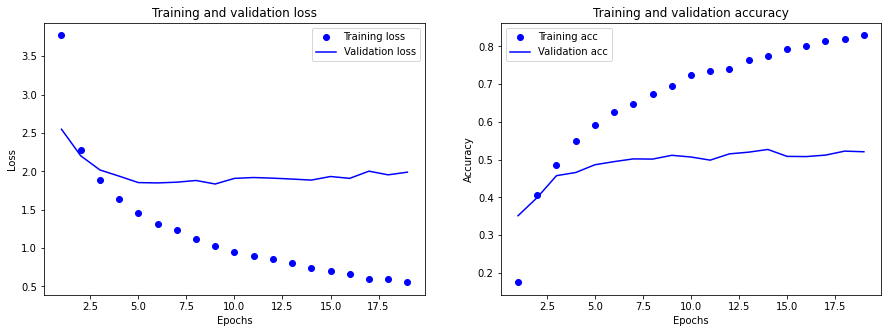


Full training set accuracy: 0.8543
Full test set accuracy: 0.5211

Listing of first twenty test labels and predictions
y_test_labels [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
Predictions   [ 0  0  0 59  0  0  0  0  2  0 33  1  1 48  1  2 48  2  1 40]

Test set F1 (weighted average): 0.51649339061111


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
#Plot Training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

#Plot Training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# evaluate fitted model on the full training set
train_loss, train_acc = model.evaluate(train_generator, steps=132, verbose = 3)
train_acc_r = np.round(train_acc, decimals = 4)
print('\nFull training set accuracy:', '{:6.4f}'.format(train_acc_r))

# evaluate the fitted model on the hold-out test set
test_loss, test_acc = model.evaluate(test_generator, steps=60, verbose = 3)
test_acc_r = np.round(test_acc, decimals = 4)
print('Full test set accuracy:','{:6.4f}'.format(test_acc_r))

# examine the predicted values
predictions = model.predict_generator(test_generator, steps=61)
val_pred = np.argmax(predictions, axis=-1)
val_true = test_generator.classes

print('\nListing of first twenty test labels and predictions')
print('y_test_labels', val_true[:20])
print('Predictions  ', val_pred[:20])

#calculate f1 score
f1_score = metrics.precision_recall_fscore_support(val_true, val_pred, \
                                                   average='weighted')[2]
print("\nTest set F1 (weighted average):", f1_score)


## Freeze Model and Save


In [0]:
import tensorflow.compat.v1 as tf  
tf.disable_v2_behavior()
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from sklearn import metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Instructions for updating:
non-resource variables are not supported in the long term


In [0]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/My Drive/Northwestern/MSDS462/Final Project/model_20200606.h5')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1280)              1639680   
_________________________________________________________________
dense_1 (Dense)              (None, 181)               231861    
Total params: 4,129,525
Trainable params: 1,871,541
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.

    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ''
        frozen_graph = tf.graph_util.convert_variables_to_constants(
            session, input_graph_def, output_names, freeze_var_names)
        return frozen_graph

In [0]:
#Create .pb file

# inputs: 
print('inputs: ', [input.op.name for input in model.inputs])

# outputs: 
print('outputs: ', [output.op.name for output in model.outputs])

frozen_graph = freeze_session(tf.keras.backend.get_session(), output_names=[out.op.name for out in model.outputs])
#frozen_graph = freeze_session(tf.keras.backend.get_session(), output_names=['dense_1/Identity'])
tf.train.write_graph(frozen_graph, './', 'mobilenetv2.pbtxt', as_text=True)
tf.train.write_graph(frozen_graph, './', 'mobilenetv2.pb', as_text=False)


inputs:  ['mobilenetv2_1.00_224_input']
outputs:  ['dense_1/Softmax']
INFO:tensorflow:Froze 277 variables.
INFO:tensorflow:Converted 277 variables to const ops.


'./mobilenetv2.pb'